Bonner et al, 2018  
Causal Embeddings for Recommendation  

打出 紘基

これから話す事

## 始めに

推薦モデルは過去のログデータを元に推薦を行なっている  
しかし、過去のログデータは既存の推薦方策によって観測されるかが決まっている  
→観測確率が一様ではない  

過去ログに対するモデルの性能ではなく、  
ユーザー×アイテムの行列全体に対するモデルの性能が知りたい  

ログデータがMNARな事によって間違った結果を導いてしまう例  
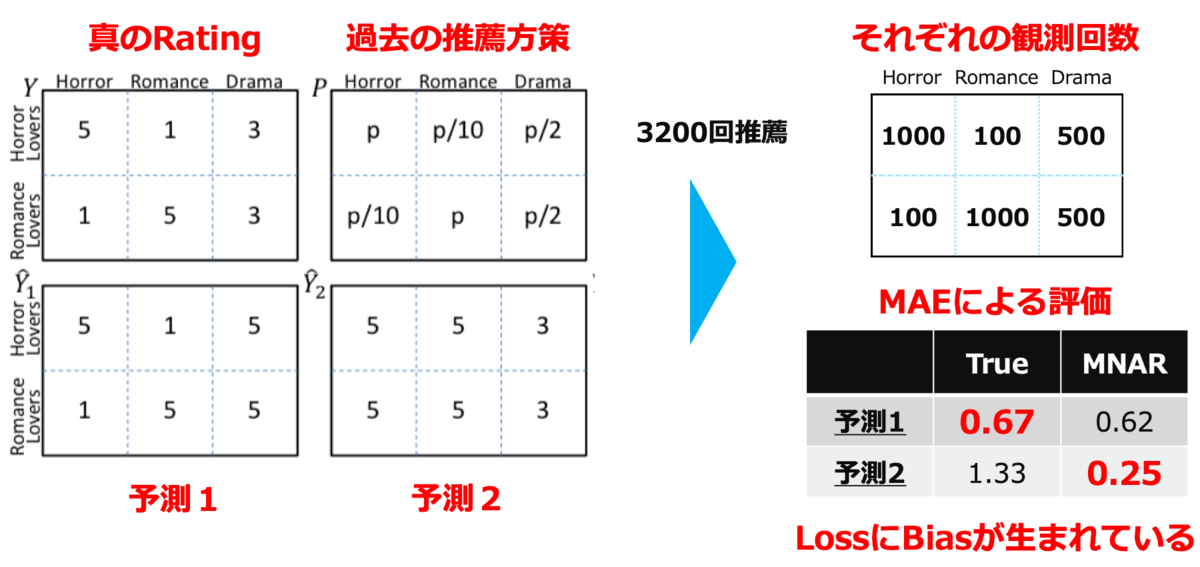

指摘内容  
観測するかがMARでなくMNARであるならば、傾向スコアを計算出来ないのでは？  
傾向スコアが計算出来るなら、欠測するかが欠測値や未観測の他の変数に依存していないので、MNARでは無くMAR  

思ったこと  
上記の例にあるように、ユーザーやアイテムがカテゴリ毎にクラスタリングされていて、観測するかがクラスターの組み合わせによって全て説明できるなら、それはMAR　に近そう→過去の推薦ログ自体から傾向スコアが計算できるので、Biasを取り除いた損失関数は真の損失関数の不偏推定量になる  
一方で、個人毎に観測確率が異なる場合、正確な傾向スコアを求めるためには外部から何か情報を渡さないと難しそう  
個人毎の傾向スコアを求めたいが、(u,i)に対して観測されるかどうかを表すデータは1つしかない  

過去の推薦方策は、評価が高そうな(ユーザー, アイテム)のペアに対してより多くの推薦を行なっている  
新たな推薦モデルを考える時、実際の評価は低いのに評価を高く予測してしまっても、過去の推薦方策がその項目に対してあまり推薦をしていなかった場合、Lossに反映されない  
逆に、実際の評価が高い項目に低く予測をしてしまうと、Lossに過剰に反映される  
→過去の推薦方策においてあまり推薦されなかった項目は、上手く予測が出来ない  

他にも、既存の推薦方策では観測割合が高いアイテム(人気なアイテム)が推薦されやすい、などの問題がある  

## 論文の要旨

推薦モデルでよく使われる行列分解モデルは、ログの欠測割合がMNARである事を考慮していない  
損失関数にIPSを加えるアプローチもあるが、treatmentとcontrolの間で確率に大きな差がある場合、上手く対処できない  
そこで学習用データを
* $S_t$: ランダムな推薦方策によって集められた、少数だがバイアスのかかっていないデータ群  
* $S_c$: 既存の推薦方策によって集められた、多数だがバイアスのかかっているデータ群  

に分け、損失関数に明示的に組み合わせた  
これにより、(ユーザー×アイテム)の行列全体に対する損失を改善した  

前提

## 始めに

推薦モデルは過去のログデータを元に推薦を行なっている  
しかし、過去のログデータは既存の推薦方策によって観測されるかが決まっている  
→観測確率が一様ではない  

過去ログに対するモデルの性能ではなく、  
ユーザー×アイテムの行列全体に対するモデルの性能が知りたい  

## 目標設定

真の損失関数$L(\cdot)$、つまり(ユーザー×アイテム)全ての組み合わせに対する損失を最小化する  
予測値集合$\hat{R} = \{\hat{r}_{u,i}\}_{(u,i) \in U\times I}$を得たい  

## 定義1
$u$: user  
$i$: item  
$\pi$: recommendation policy = 観測確率   
$\pi_c$: control recommendation policy、既存の推薦方策  
$\pi_t$: treatment recommendation policy、新しい推薦方策  
$\pi^{rand}$: random recommendation policy  
$o_{u,i}$: 方策$\pi_{\it{x}}$に従って決まった、$r_{u,i}$が観測されるかを表す{0,1}の2値変数  
$r_{u,i}$: ユーザー, 属性毎の真の評価値  
$y_{u,i}$: ユーザー, 属性毎の観測評価値(大半は未知)  
$L(\hat{R})$: 真の損失関数  
$\hat{R}$: 予測値集合

簡便のため、$(u,i)$が決まれば$r_{u,i}$は一意に定まるとする  

$\pi_{\it{x}}$の$x$って要はここに何かが入りますよ、ってこと？  
→$\it{x}$はユーザー集合、確かにユーザー毎に$t, c$に分けたいけど、ユーザー体験的にどうなの... ？  
説明だるいので消す

## 定義2
$$
o_{u,i} \sim Bern(o_{u,i} | \pi(u,i)) \\
E[o_{u,i}] = \pi(u,i) \\
y_{u,i} = r_{u,i} o_{u,i} \\
$$

欠測が起こっている評価値を0埋めするイメージ

論文の概要

## 真の損失関数

理想的には、以下の式で表される損失関数を用いたい
$$
L(\hat{R}) = \frac{1}{U \cdot I} \sum_{u,i} \delta (r_{u,i}, \hat{r}_{u,i})
$$

ここで、$\delta(\cdot)$は任意の損失関数、MSEやCrossEntropyなど  

しかし、実際に手に入るのは$r_{u,i}$ではなく$y_{u,i} = o_{u,i} r_{u,i}$  
従って、真の損失関数を直接最小化することは出来ない

## naiveな損失関数

観測値$y_{u,i} = o_{u,i} r_{u,i}$をそのまま用いると、以下のような損失関数が出来る  

$$
\hat{L}_{naive}(\hat{R}) = \frac{1}{|S_c|} \sum_{(u,i) \in S_c} \delta(y_{u,i}, \hat{r}_{u,i}) \\
S_c = \{(u, i, y_{u,i}): o_{u,i} = 1 \} \\
E[o_{u,i}] = \pi_c(u,i)
$$

$\pi_c$は、観測値=過去の推薦ログを生成した、既存の推薦方策  

### naiveな損失関数は真の損失関数の不偏推定量ではない
$O$について期待値をとる
$$ 
\begin{equation}
\begin{split}
\hat{L}_{naive}(\hat{R}) &= \frac{1}{|S_c|} \sum_{(u,i) \in S_c} \delta(y_{u,i}, \hat{r}_{u,i}) \\
E_{O}[\hat{L}_{naive}] & = E_{O}\left[\frac{1}{|S_c|} \sum_{u,i} o_{u,i} \delta(r_{u,i}, \hat{r}_{u,i}) \right] \\
&= \frac{1}{|S_c|} \sum_{u,i} E_{o_{u,i}}[o_{u,i}] \delta(r_{u,i}, \hat{r}_{u,i}) \\
&=  \sum_{u,i} \frac{\pi_c(u,i)}{|S_c|} \delta(r_{u,i}, \hat{r}_{u,i})
\end{split}
\end{equation}
$$

真の損失関数と比較
$$
L(\hat{R}) = \frac{1}{U \cdot I} \sum_{u,i} \delta (r_{u,i}, \hat{r}_{u,i}) \\
E_{O}[\hat{L}_{naive}]  = \sum_{u,v} \frac{\pi_c(u,i)}{|S_c|}{|S_c|} \delta(r_{u,i}, \hat{r}_{u,r})
$$  
$L(\hat{R}) = E_{O}[\hat{L}_{naive}]$が成り立つためには任意の$u,i$に対して
$$
\frac{\pi_c(u,i)}{|S_c|}{|S_c|} = \frac{1}{U \cdot I}
$$  
が必要だが、実際はそうではない  
($(u,i)$の組み合わせによって、観測確率は異なる)

## 既存手法: IPS推定量を使用

$$
p_{u,i} = \pi_c(u,i) = E[o_{u,i}] \\
\hat{L}_{IPS}(\hat{R}) = \frac{1}{U \cdot I} \sum_{(u,i): o_{u,i}=1} \frac{\delta(r_{u,i}, \hat{r}_{u,i})}{p_{u,i}} \\
$$

naiveな損失関数は$\frac{1}{|S|}$で割っていたけど、IPSは$\frac{1}{U \cdot I}$で割る

## IPS推定量$\hat{L}_{IPS}(\hat{R})$は$L(\hat{R})$の不偏推定量になる

$$
\begin{equation}
\begin{split}
\hat{L}_{IPS}(\hat{R}) &= \frac{1}{U \cdot I} \sum_{(u,i): o_{u,i}=1} \frac{\delta(r_{u,i}, \hat{r}_{u,i})}{p_{u,i}} \\
E_{O}[\hat{L}_{IPS}(\hat{R})] &= E_{O}\left[\frac{1}{U \cdot I} \sum_{u,i} o_{u,i} \frac{\delta(r_{u,i}, \hat{r}_{u,i})}{p_{u,i}}\right] \\
&= \frac{1}{U \cdot I} \sum_{u,i} \frac{E_{o_{u,i}}[o_{u,i}]}{p_{u,i}} \delta(r_{u,i}, \hat{r}_{u,i}) \\
&= \frac{1}{U \cdot I} \sum_{u,i} \delta(r_{u,i}, \hat{r}_{u,i}) \\
&= L(\hat{R})
\end{split}
\end{equation}
$$

## 既存手法の問題点

IPS推定量で補正すると、treatmentとcontrolで割り当て確率に大きな差があった時に上手く対処出来ない  
既存の方策$\pi_c$で確率の低いアイテムは$\hat{r}_{i,j}$を高めに見積もってしまうらしい(Bottou et al, 2013)  
とはいえ、割り当て確率を均等にするため$\pi_c = \pi^{rand}$にすると、既存のレコメンド精度を下げてしまう  
↓  
バイアスのかかったデータ集合$S_c$を使ってデータが$\pi^{rand}$に従って集められた時のアウトカムを予測するように学習したい  
つまり、$\hat{L}(r_{u,i}, \hat{r}_{u,i})=L(r_{u,i}, \hat{r}_{u,i})$となるように、データ集合$S_c$を補正したい  

## $\hat{L}_{naive}(\hat{R})$を$\pi^{rand}$によって集めた$S_t$に当てはめる

$$
S_t = \{(u, i, y_{u,i}): o_{u,i} = 1 \} \\
E[o_{u,i}] = \pi_t(u,i) = \pi^{rand} = \frac{C \cdot |S_t|}{U \cdot I} \\
\hat{L}_{naive}(\hat{R}) = \frac{1}{|S_t|} \sum_{(u,i) \in S_t} \delta(y_{u,i}, \hat{r}_{u,i}) 
$$
Cは定数

### (再掲)naiveな損失関数は真の損失関数の不偏推定量ではない
$O$について期待値をとる
$$ 
\begin{equation}
\begin{split}
\hat{L}_{naive}(\hat{R}) &= \frac{1}{|S_c|} \sum_{(u,i) \in S_c} \delta(y_{u,i}, \hat{r}_{u,i}) \\
E_{O}[\hat{L}_{naive}] & = E_{O}\left[\frac{1}{|S|} \sum_{u,i} o_{u,i} \delta(r_{u,i}, \hat{r}_{u,i}) \right] \\
&= \frac{1}{|S_c|} \sum_{u,i} E_{o_{u,i}}[o_{u,i}] \delta(r_{u,i}, \hat{r}_{u,i})
\end{split}
\end{equation}
$$

### $S_t$に対する$\hat{L}_{naive}(\hat{R})$は$L(\hat{R})$に比例

$$
\begin{equation}
\begin{split}
E_{O}[\hat{L}_{naive}] &= \frac{1}{|S_t|} \sum_{u,i} E_{o_{u,i}}[o_{u,i}] \delta(r_{u,i}, \hat{r}_{u,i}) \\
&= \frac{1}{|S_t|} \sum_{u,i} \frac{C \cdot |S_t|}{U \cdot I} \delta(r_{u,i}, \hat{r}_{u,i}) \\
&= \frac{1}{|S_t|} \frac{C \cdot |S_t|}{U \cdot I} \sum_{u,i} \delta(r_{u,i}, \hat{r}_{u,i}) \\
&= C \cdot \frac{1}{U \cdot I} \sum_{u,i} \delta(r_{u,i}, \hat{r}_{u,i}) \\
&\propto L(\hat{R})
\end{split}
\end{equation}
$$
よって、$\hat{L}_{naive}(\hat{R})$を最適化する学習は妥当

Causal Embeddings

## 行列分解と損失関数

推薦システムでよく使われる手法、ユーザーとアイテムに対するEmbeddingsを手に入れる  
$$
r_{u,i} \approx \gamma_u^{\mathsf{T}} \theta_t \\
R \approx \Gamma \Theta^{\mathsf{T}} \\
$$
ただし  
$\Gamma$: U行D列の行列、ユーザーのEmbeddingsを表す  
$\Theta$: I行D列の行列、アイテムのEmbeddingsを表す  
$D$: 潜在次元数、恣意的に決める、ユーザーとアイテムで共通  

損失関数$l(r_{u,i}, \gamma_u^{\mathsf{T}} \theta_t)$にはMSE, Cross Entropyなどが使われる

## Causal Embeddings(CausE)の損失関数

$$
\begin{equation}
\begin{split}
\hat{L}_{CausE} &= \sum_{(u,i) \in S_t} l(y_{i,t}, \gamma_{u,t}^T \theta_{i,t}) + \lambda_t(\gamma_{u,t}, \theta_{i,t})\\
&+ \sum_{(u,i) \in S_c} l(y_{i,c}, \gamma_{u,c}^T \theta_{i,c}) + \lambda_c(\gamma_{u,c}, \theta_{i,c}) \\
&+ \lambda_{dist} \left( \sum_{u \in U} ||\gamma_{u,t} - \gamma_{u,c}||_p + \sum_{i \in I} ||\theta_{i,t} - \theta_{i,c}||_p \right)
\end{split}
\end{equation}
$$

上から順に  
$S_t$に対する行列分解+正則化項  
$S_c$に対する行列分解+正則化項  
$\gamma_{u,c}, \theta_{i,c}$が$\gamma_{u,t}, \theta_{i,c}$から離れすぎないようにする正則化項($\gamma_{u,c}, \theta_{i,c}$に対してのみ使用)  

## CausEで学習させる係数

データ群$S_t$で学習させるユーザー、アイテムの行列$\Gamma_t, \Theta_t$  
データ群$S_c$で学習させるユーザー、アイテムの行列$\Gamma_c, \Theta_c$  

## CausEで予め設定しておくパラメータ

正則化項$\lambda_t, \lambda_c, \lambda_{dist}$

## CausEの学習


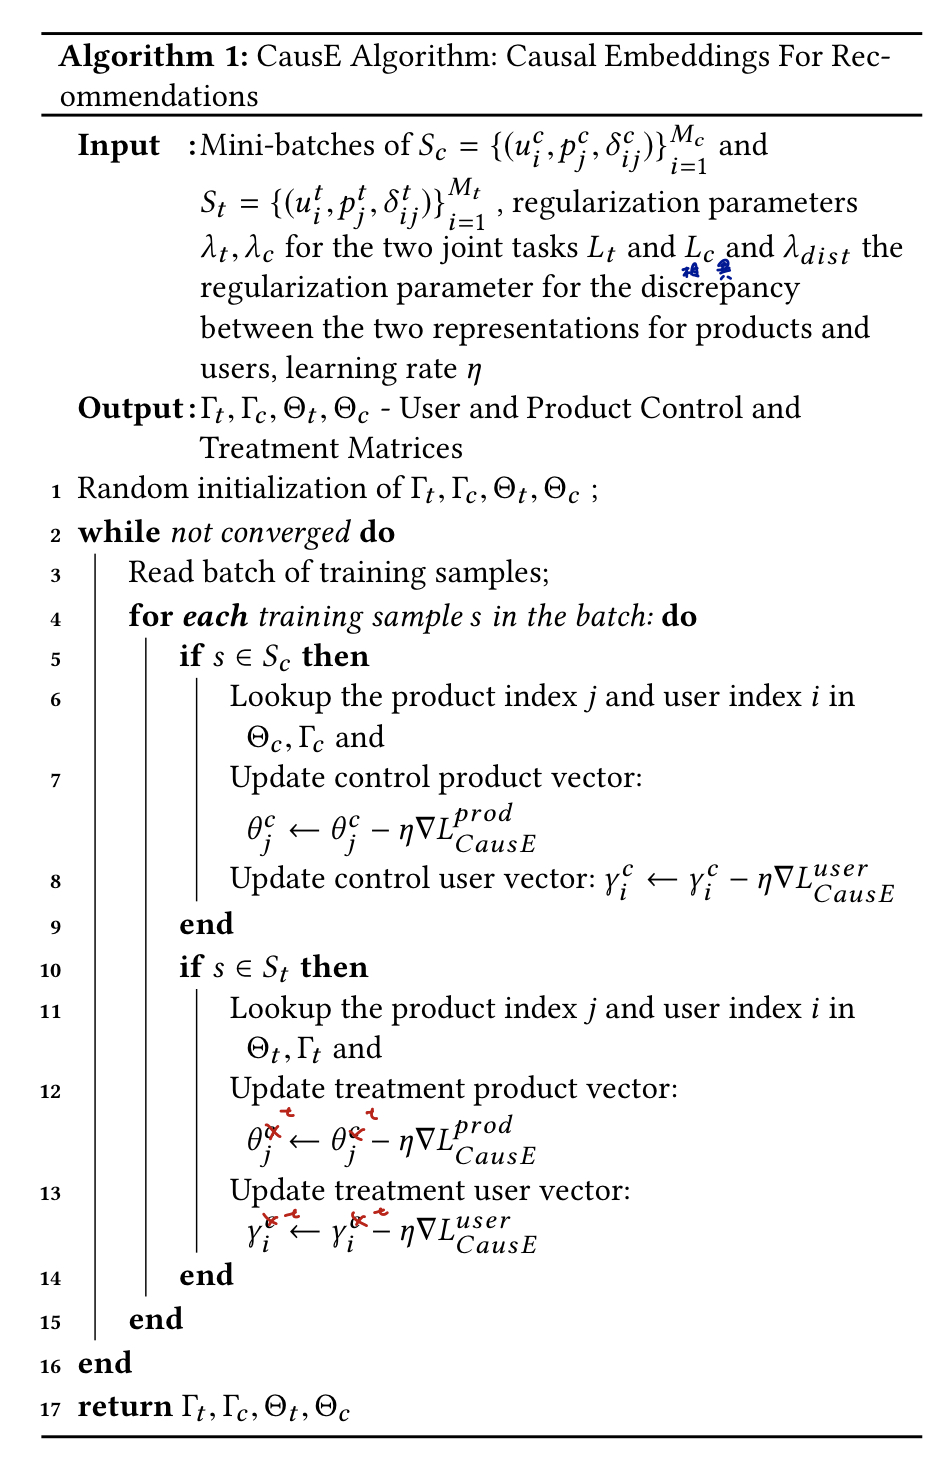

## CausEを用いた予測

学習の結果求められた$\Gamma_t, \Theta_t$、あるいは$\Gamma_c, \Theta_t$を用いて予測

実データに適用した結果

## 実データ

1. データを(星5/その他)でバイナリ化
2. 通常のデータセットREGと、観測確率のバイアスを取り除いたデータセットSKEWを作成

## 比較手法

BPR: Bayesian Personalized Ranking  
行列分解を「ユーザーはアイテムiよりアイテムjを好む」というランキング  
$l(u,i,j) = \sum_{(u,i,j) \in D_s}\ln \sigma(\gamma_u^{\mathsf{T}} \theta_i - \gamma_u^{\mathsf{T}} \theta_j) + \omega(\gamma_u, \theta_i, \theta_j)$  

SP2V: Supervised-Prod2Vec  
$\hat{y}_{i,j} = \sigma(\alpha \gamma_u^{\mathsf{T}} \theta_i + b_u + b_i + b)$  

WSP2V: Weghted-SupervisedP2V、SP2Vを傾向スコアで逆重み付け  

BN: BanditNet、DNNを文脈付きバンディットに対して適用、損失関数に逆重み付け  

## 評価値: lift

$$
lift_{x}^{metric} = \frac{metric_x - metric_{AvgCR}}{metric_{AvgCR}}
$$
$x$: モデル  
$avgCR$: テストデータのratingの平均で全埋め  
バイナリの評価にはAUCを使う？  

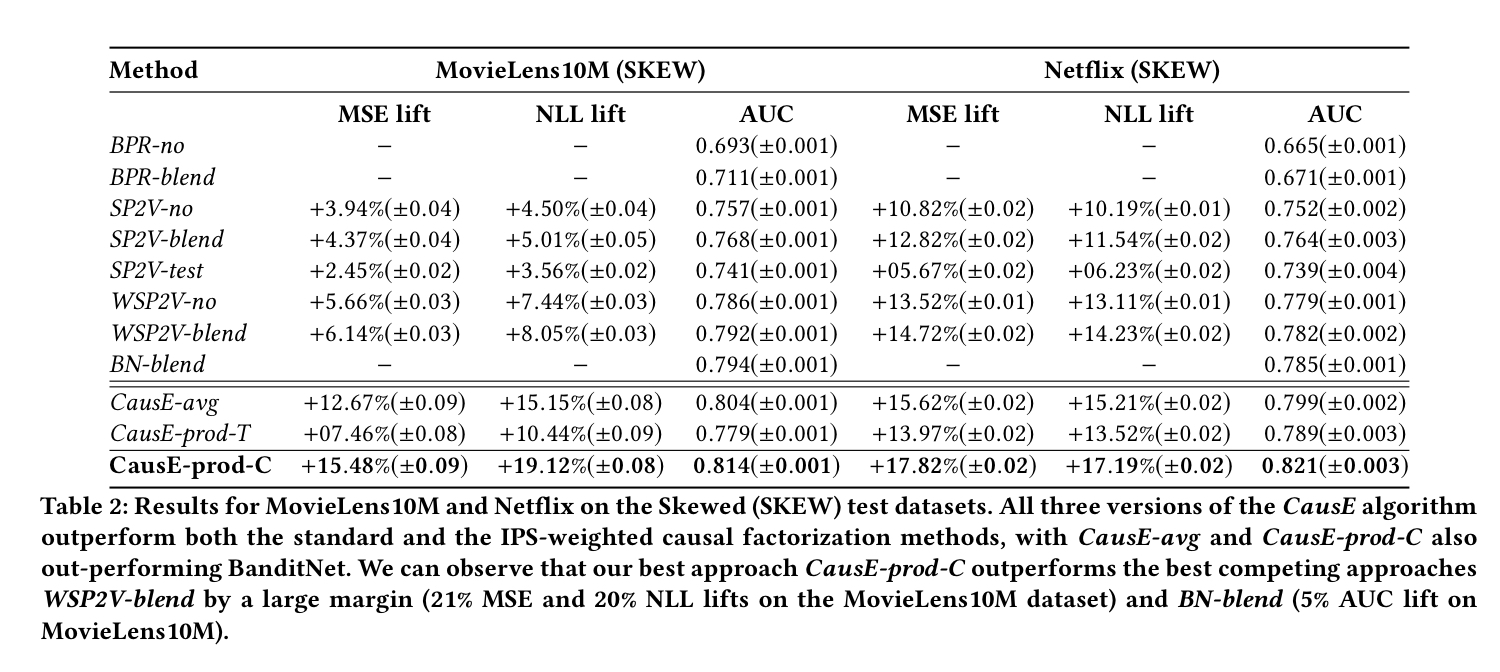

まとめ

## まとめ

推薦モデルでよく使われる行列分解モデルは、ログの欠測割合がMNARである事を考慮していない  
損失関数にIPSを加えるアプローチもあるが、treatmentとcontrolの間で確率に大きな差がある場合、上手く対処できない  
そこで学習用データを
* $S_t$: ランダムな推薦方策によって集められた、少数だがバイアスのかかっていないデータ群  
* $S_c$: 既存の推薦方策によって集められた、多数だがバイアスのかかっているデータ群  

に分け、損失関数に明示的に組み合わせた  
これにより、(ユーザー×アイテム)の評価行列全体に対する損失を改善した  

## さらに詳しく知りたい人は...

[Causal Embeddingsの解説と追試](https://usaito.hatenablog.com/entry/2019/04/19/210650)

気になること  

ランダムなデータをサンプリングするデメリットを補うほどメリットがあるのか  
$\hat{R}$を求めなくても、サイトへの訪問頻度が多く積極的に推薦場面がある人を優先的に精度上げてけばいい？